# BT4012 In-Class Kaggle Competition

Author: Loh Hong Tak Edmund | A0199943H

Python version: 3.8.11

## Importing packages

In [1]:
# EDA
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from numpy import sort
from collections import Counter

# Oversampling
from imblearn.over_sampling import RandomOverSampler, SVMSMOTE, ADASYN


# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, recall_score, precision_score 
from sklearn.ensemble import RandomForestClassifier
import xgboost

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

# Settings
import pickle
import warnings
warnings.filterwarnings("ignore")


## Loading Data Set

In [2]:
ds = pd.read_csv('train.csv')
ds.head()

,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,r0c9,...,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19,label
0,1,1,1,1,28,43,52,255,255,255,...,191,255,52,34,1,1,1,1,1,0
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
2,1,1,128,255,255,255,255,255,255,255,...,255,255,255,255,255,255,128,1,1,0
3,53,54,61,91,141,172,197,223,233,246,...,184,185,187,169,147,106,82,34,23,1
4,46,46,46,46,36,36,41,41,41,41,...,38,65,65,95,95,149,149,205,205,0


In [3]:
Counter(ds.label)

Counter({0: 65581, 1: 6558})

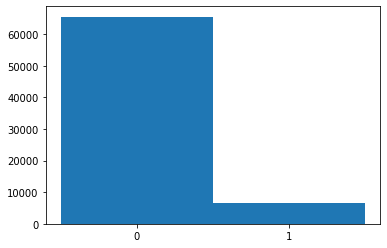

In [4]:
labels, values = zip(*Counter(ds.label).items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.show()

In [5]:
X = ds.drop('label', axis=1)
y = ds.label.values

## Preparing Training, Validation and Test Sets

In [6]:
x_train_val, x_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20,random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val,y_train_val, test_size=0.10,random_state=42)
x_train = x_train/255
x_val = x_val/255
x_test= x_test/255

## Previewing Images

In [7]:
def reshape_mat(X):
    X_mat = []
    for i in range(X.shape[0]):
        X_mat.append(np.reshape(X.iloc[i].tolist(), (20,20)).T)
    X_mat_arr = np.array(X_mat)
    X_mat_arr_ex = X_mat_arr[:,:,:,None]
    return X_mat_arr_ex

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20,20))
    r = reshape_mat(image_batch)
    for n in range(100):
        ax = plt.subplot(10,10,n+1)
        plt.imshow(r[n])
        plt.title(str(label_batch[n]))
        plt.axis("off")

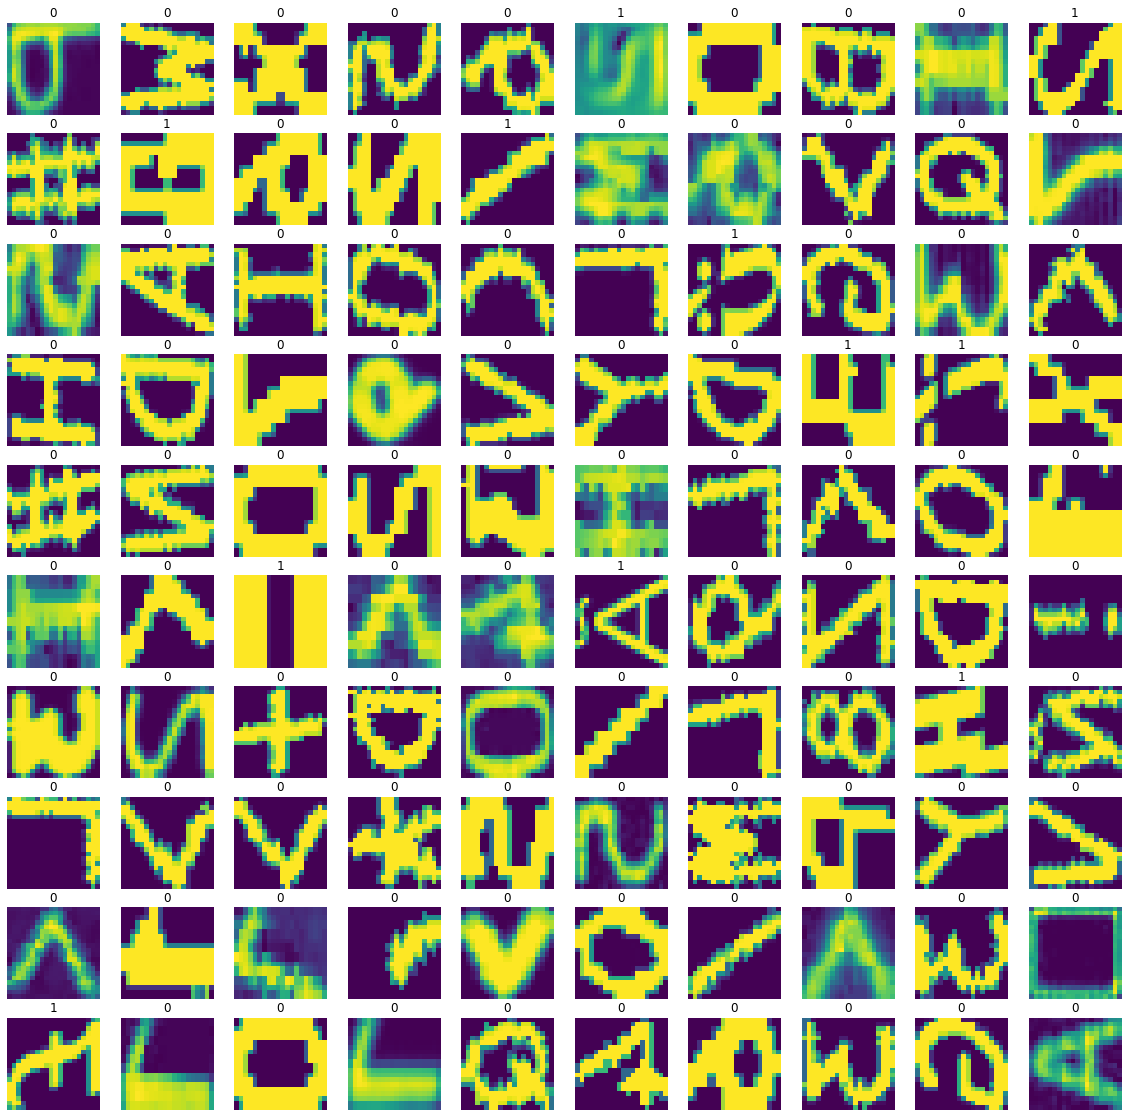

In [8]:
show_batch(x_train, y_train)


## Oversampling Train Data

- Random Oversampling
- ADASYN Oversampling
- SVM-SMOTE Oversampling


In [9]:
x_train_randoversam, y_train_randoversam = RandomOverSampler(random_state=42).fit_resample(x_train,y_train)
x_train_adasyn, y_train_adasyn = ADASYN(random_state=42).fit_resample(x_train, y_train)
x_train_svmsmote, y_train_svmsmote = SVMSMOTE(random_state=42).fit_resample(x_train, y_train)


In [10]:
for y in [y_train, y_train_randoversam, y_train_adasyn, y_train_svmsmote]:
    print(Counter(y))

Counter({0: 47196, 1: 4743})
Counter({0: 47196, 1: 47196})
Counter({1: 47319, 0: 47196})
Counter({0: 47196, 1: 47196})


In [11]:
samples = {
    "normal": (x_train,y_train),
    "random_ovesampling": (x_train_randoversam, y_train_randoversam),
    "adasyn":(x_train_adasyn, y_train_adasyn),
    "svmsmote": (x_train_svmsmote, y_train_svmsmote)
}

## Neural Networks

### Neural Network Helper Functions

In [12]:
def nn_predict_to_csv(model, name, cnn=False):
    test_ds = pd.read_csv("test.csv")
    Id = test_ds['Id'][:]
    test_ds = test_ds.drop("Id", axis=1)
    test_ds = test_ds/255
    pred = model.predict(test_ds)
    pred_df = pd.DataFrame({'Id':Id.values, 'Predicted':pred.flatten()}, columns=['Id', 'Predicted'])
    #print(pred_df)
    if cnn:
        pred_df.to_csv(f'CNN_{name}.csv', index=False)
    else:
        pred_df.to_csv(f'VNN_{name}.csv', index=False)
    return True

def nn_model_score(name, model, x, y, cnn, output_csv=True):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC', 'Recall', 'Precision']
    )

    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
                EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=12, restore_best_weights=True)]
    
    print("\n >>>> MODEL BUILDING ============================================================================ \n")
    history = model.fit(
        x, y, 
        epochs=64, 
        batch_size = 32, 
        validation_data=(x_val,y_val),
        callbacks=callbacks
    )
    print("\n >>>> MODEL EVALUATION ON TEST SET ============================================================================ \n")
    score = model.evaluate(x_test, y_test, batch_size=32)

    if output_csv:
        nn_predict_to_csv(model, name, cnn=cnn)

    return [model, history, score]

def nn_get_res_df(res):
    res_dict = {}
    for name, hist in res.items():
        scores = hist[2]
        score_dict = {
            "loss": scores[0],
            "accuracy": scores[1],
            "auc": scores[2],
            "recall": scores[3],
            "precision": scores[4]
        }
        res_dict[name] = score_dict
    return pd.DataFrame(res_dict).T

def nn_pipeline(samps, model, cnn):
    results = {}
    for name, xy in samps.items():
        print(f"\n Training {name}")
        hist = nn_model_score(name, model, xy[0], xy[1], cnn, output_csv=True)
        results[name] = hist
    return results



### Vanila Neural Network (Dense layers)

In [13]:
model_vanila = tf.keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid", name="predictions")
])

model_vanila_history = nn_pipeline(samples, model_vanila, cnn=False)


 Training normal

 >>>> MODEL BUILDING ============================================================================ 

Epoch 1/64
1624/1624 [==============================] - 18s 9ms/step - loss: 0.2653 - accuracy: 0.9093 - auc: 0.7644 - recall: 0.0160 - precision: 0.6387 - val_loss: 0.2373 - val_accuracy: 0.9118 - val_auc: 0.8495 - val_recall: 0.0862 - val_precision: 0.8103
Epoch 2/64
1624/1624 [==============================] - 15s 9ms/step - loss: 0.2299 - accuracy: 0.9229 - auc: 0.8364 - recall: 0.2709 - precision: 0.7018 - val_loss: 0.2609 - val_accuracy: 0.9316 - val_auc: 0.8917 - val_recall: 0.3376 - val_precision: 0.8440
Epoch 3/64
1624/1624 [==============================] - 15s 9ms/step - loss: 0.2195 - accuracy: 0.9269 - auc: 0.8514 - recall: 0.3222 - precision: 0.7242 - val_loss: 0.3068 - val_accuracy: 0.9354 - val_auc: 0.8871 - val_recall: 0.3798 - val_precision: 0.8554
Epoch 4/64
1624/1624 [==============================] - 14s 9ms/step - loss: 0.2127 - accuracy: 0.9291 -

In [14]:
model_vanila_results = nn_get_res_df(model_vanila_history)
model_vanila_results

,loss,accuracy,auc,recall,precision
normal,0.173208,0.948226,0.931792,0.601575,0.760199
random_ovesampling,0.475498,0.778625,0.935396,0.918898,0.274072
adasyn,0.453591,0.760812,0.922126,0.918110,0.258365
svmsmote,0.416790,0.812795,0.938497,0.918110,0.309859


### Convolutional Neural Network

In [15]:
model_cnn = tf.keras.Sequential([
    layers.Reshape(target_shape=(20, 20, 1), input_shape=(400,)),
    layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer=l2(0.000001), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.000001)),
    layers.Dense(32, activation='relu', kernel_regularizer=l2(0.000001)),
    layers.Dense(1, activation='sigmoid')
])

model_cnn_history = nn_pipeline(samples, model_cnn, cnn=True)


 Training normal

 >>>> MODEL BUILDING ============================================================================ 

Epoch 1/64
1624/1624 [==============================] - 36s 19ms/step - loss: 0.1514 - accuracy: 0.9495 - auc: 0.9302 - recall: 0.5832 - precision: 0.8104 - val_loss: 0.3986 - val_accuracy: 0.8051 - val_auc: 0.9277 - val_recall: 0.9028 - val_precision: 0.3146
Epoch 2/64
1624/1624 [==============================] - 30s 19ms/step - loss: 0.0994 - accuracy: 0.9657 - auc: 0.9718 - recall: 0.7388 - precision: 0.8660 - val_loss: 0.1026 - val_accuracy: 0.9652 - val_auc: 0.9697 - val_recall: 0.7780 - val_precision: 0.8413
Epoch 3/64
1624/1624 [==============================] - 32s 20ms/step - loss: 0.0791 - accuracy: 0.9733 - auc: 0.9814 - recall: 0.8065 - precision: 0.8904 - val_loss: 0.0856 - val_accuracy: 0.9705 - val_auc: 0.9785 - val_recall: 0.7523 - val_precision: 0.9213
Epoch 4/64
1624/1624 [==============================] - 32s 20ms/step - loss: 0.0656 - accuracy: 0.97

In [16]:
model_cnn_results = nn_get_res_df(model_cnn_history)
model_cnn_results 

,loss,accuracy,auc,recall,precision
normal,0.071269,0.979207,0.986383,0.874016,0.888000
random_ovesampling,0.097848,0.977682,0.971687,0.838583,0.901015
adasyn,0.121723,0.976296,0.973885,0.903937,0.839181
svmsmote,0.119574,0.977474,0.979441,0.910236,0.845647


## Ensemble Methods

### Ensemble Methods Helper Functions

In [17]:
from keras import backend
from keras.losses import binary_crossentropy

In [18]:
def ens_get_bceloss(pred,true):
    y_true = backend.variable(true)
    y_pred = backend.variable(pred)
    mean_ce = backend.eval(binary_crossentropy(y_true, y_pred))
    return mean_ce

def ens_get_auc(y_pred_proba, y):
    [fpr, tpr, thr] = roc_curve(y, y_pred_proba)
    return auc(fpr, tpr)

def ens_get_results_dict(model):
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:,1]
    score_dict = {
        "loss": ens_get_bceloss(y_pred_proba, y_test),
        "accuracy": accuracy_score(y_test, y_pred),
        "auc": ens_get_auc(y_pred_proba, y_test),
        "recall": recall_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred)
    }
    return score_dict

def ens_pred_test_to_csv(model, name, xgb=False):
    test_ds = pd.read_csv("test.csv")
    Id = test_ds['Id'][:]
    test_ds = test_ds.drop("Id", axis=1)
    test_ds = test_ds/255
    pred_proba = model.predict_proba(test_ds)
    pred_proba_1 = []
    for i in pred_proba:
        pred_proba_1.append(i[1])
    pred_df = pd.DataFrame({'Id':Id.values, 'Predicted':pred_proba_1}, columns=['Id', 'Predicted'])
    #print(pred_df)
    if xgb:
        pred_df.to_csv(f'xgb_{name}.csv', index=False)
    else:
        pred_df.to_csv(f'rf_{name}.csv', index=False)

def ens_pipeline(samps,model,csv_output=True,xgb=False):
    res = {}
    for name, sample in samps.items():
        print(f"\n Training {name} in progress ")
        model.fit(sample[0],sample[1])
        score = ens_get_results_dict(model)
        res[name] = score
        print(f"\n Training {name} completed ")
        if csv_output:
            ens_pred_test_to_csv(model, name, xgb=xgb)
    print("\n Pipeline Completed Successfully")
    return pd.DataFrame(res).T




In [19]:
xgb = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_res = ens_pipeline(samples, xgb,xgb=True)
xgb_res


 Training normal in progress 

 Training normal completed 

 Training random_ovesampling in progress 

 Training random_ovesampling completed 

 Training adasyn in progress 

 Training adasyn completed 

 Training svmsmote in progress 

 Training svmsmote completed 

 Pipeline Completed Successfully


,loss,accuracy,auc,recall,precision
normal,0.072363,0.973870,0.988421,0.765354,0.924833
random_ovesampling,0.075374,0.973108,0.986509,0.856693,0.840804
adasyn,0.091600,0.968949,0.980508,0.827559,0.821094
svmsmote,0.101665,0.964791,0.976424,0.815748,0.790840


In [20]:
rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf_res = ens_pipeline(samples,rf, xgb=False)
rf_res


 Training normal in progress 

 Training normal completed 

 Training random_ovesampling in progress 

 Training random_ovesampling completed 

 Training adasyn in progress 

 Training adasyn completed 

 Training svmsmote in progress 

 Training svmsmote completed 

 Pipeline Completed Successfully


,loss,accuracy,auc,recall,precision
normal,0.108902,0.961048,0.989423,0.577165,0.967018
random_ovesampling,0.109549,0.963404,0.989887,0.617323,0.949153
adasyn,0.146434,0.966038,0.982927,0.754331,0.843310
svmsmote,0.131838,0.969434,0.986717,0.743307,0.891407


In [21]:
rf_res

,loss,accuracy,auc,recall,precision
normal,0.108902,0.961048,0.989423,0.577165,0.967018
random_ovesampling,0.109549,0.963404,0.989887,0.617323,0.949153
adasyn,0.146434,0.966038,0.982927,0.754331,0.843310
svmsmote,0.131838,0.969434,0.986717,0.743307,0.891407
